In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,r2_score, mean_absolute_error, mean_squared_error,classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import QuantileTransformer,StandardScaler
from sklearn.compose import TransformedTargetRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline




In [2]:
df=pd.read_csv("https://vikas-bucket0809.s3.ca-central-1.amazonaws.com/train.csv")
df.drop(['policy_id','area_cluster','length','width','height','gross_weight','displacement','turning_radius','is_front_fog_lights','is_rear_window_wiper'], axis=1,inplace=True)
df.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,segment,model,fuel_type,max_torque,max_power,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0.515874,0.05,0.644231,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
1,0.672619,0.02,0.375000,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
2,0.841110,0.02,0.384615,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,No,No,No,Yes,No,No,No,Yes,0,0
3,0.900277,0.11,0.432692,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,...,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,2,0
4,0.596403,0.11,0.634615,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,...,No,Yes,Yes,Yes,No,Yes,Yes,Yes,2,0


In [3]:
column_list = list(df.select_dtypes(include=['O']).columns)
column_list

['segment',
 'model',
 'fuel_type',
 'max_torque',
 'max_power',
 'engine_type',
 'is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'rear_brakes_type',
 'transmission_type',
 'steering_type',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert']

In [4]:
import re
binary_cols=[cols for cols in column_list if re.search(r'^is_',cols)]
binary_cols

['is_esc',
 'is_adjustable_steering',
 'is_tpms',
 'is_parking_sensors',
 'is_parking_camera',
 'is_rear_window_washer',
 'is_rear_window_defogger',
 'is_brake_assist',
 'is_power_door_locks',
 'is_central_locking',
 'is_power_steering',
 'is_driver_seat_height_adjustable',
 'is_day_night_rear_view_mirror',
 'is_ecw',
 'is_speed_alert']

In [5]:
# labelEncoder present in scikitlearn library
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for x in binary_cols:
    df[x] = le.fit_transform(df[x])
df.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,make,segment,model,fuel_type,max_torque,max_power,...,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim
0,0.515874,0.05,0.644231,4990,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,0,0,0,1,0,0,0,1,0,0
1,0.672619,0.02,0.375000,27003,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,0,0,0,1,0,0,0,1,0,0
2,0.841110,0.02,0.384615,4076,1,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,...,0,0,0,1,0,0,0,1,0,0
3,0.900277,0.11,0.432692,21622,1,C1,M2,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,...,1,1,1,1,1,1,1,1,2,0
4,0.596403,0.11,0.634615,34738,2,A,M3,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,...,0,1,1,1,0,1,1,1,2,0


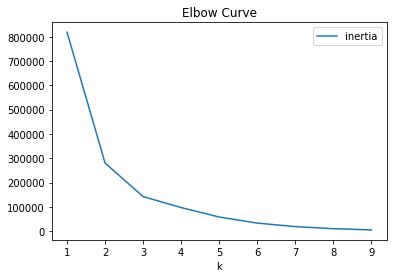

In [6]:
features=['model','segment','make']
for x in features:
    df[x] = le.fit_transform(df[x])
inertia=[]
k=list(range(1,10))
#Looking for best value of k
for i in k:
    km=KMeans(n_clusters=i,random_state=0)
    km.fit(df[features])
    inertia.append(km.inertia_)

# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.plot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)


In [7]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df[features])
df['car_features'] = kmeans.predict(df[features])
df['car_features']
df.drop(features,axis=1,inplace=True)
df.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,...,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,car_features
0,0.515874,0.05,0.644231,4990,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,0,...,0,0,1,0,0,0,1,0,0,2
1,0.672619,0.02,0.375000,27003,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,0,...,0,0,1,0,0,0,1,0,0,2
2,0.841110,0.02,0.384615,4076,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,0,...,0,0,1,0,0,0,1,0,0,2
3,0.900277,0.11,0.432692,21622,Petrol,113Nm@4400rpm,88.50bhp@6000rpm,1.2 L K12N Dualjet,2,1,...,1,1,1,1,1,1,1,2,0,0
4,0.596403,0.11,0.634615,34738,Petrol,91Nm@4250rpm,67.06bhp@5500rpm,1.0 SCe,2,0,...,1,1,1,0,1,1,1,2,0,0


We are performing same steps of clustering as above.Here we are clustering car engine features like torque,power and engine type.

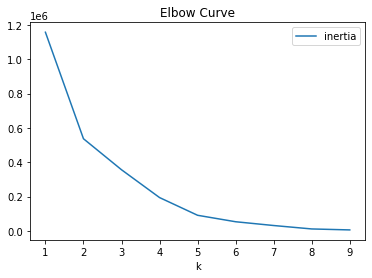

In [8]:
features=['max_torque','max_power','engine_type']
for x in features:
    df[x] = le.fit_transform(df[x])
inertia=[]
k=list(range(1,10))
#Looking for best value of k
for i in k:
    km=KMeans(n_clusters=i,random_state=0)
    km.fit(df[features])
    inertia.append(km.inertia_)

# Define a DataFrame to plot the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.plot.line(x="k", y="inertia", title="Elbow Curve", xticks=k)

In [9]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df[features])
df['power_range'] = kmeans.predict(df[features])
df['power_range']
df.drop(features,axis=1,inplace=True)
df.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,fuel_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,...,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,is_claim,car_features,power_range
0,0.515874,0.05,0.644231,4990,CNG,2,0,0,0,1,...,0,1,0,0,0,1,0,0,2,0
1,0.672619,0.02,0.375000,27003,CNG,2,0,0,0,1,...,0,1,0,0,0,1,0,0,2,0
2,0.841110,0.02,0.384615,4076,CNG,2,0,0,0,1,...,0,1,0,0,0,1,0,0,2,0
3,0.900277,0.11,0.432692,21622,Petrol,2,1,1,0,1,...,1,1,1,1,1,1,2,0,0,4
4,0.596403,0.11,0.634615,34738,Petrol,2,0,0,0,0,...,1,1,0,1,1,1,2,0,0,2


In [10]:
ohe_cols=list(df.select_dtypes(include=['O']).columns)
ohe_cols

['fuel_type', 'rear_brakes_type', 'transmission_type', 'steering_type']

In [11]:
ohe_df=pd.get_dummies(df[ohe_cols])
df=pd.concat([df, ohe_df], axis=1)
df=df.drop(columns=ohe_cols)
df.head()

,policy_tenure,age_of_car,age_of_policyholder,population_density,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,...,fuel_type_CNG,fuel_type_Diesel,fuel_type_Petrol,rear_brakes_type_Disc,rear_brakes_type_Drum,transmission_type_Automatic,transmission_type_Manual,steering_type_Electric,steering_type_Manual,steering_type_Power
0,0.515874,0.05,0.644231,4990,2,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1
1,0.672619,0.02,0.375000,27003,2,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1
2,0.841110,0.02,0.384615,4076,2,0,0,0,1,0,...,1,0,0,0,1,0,1,0,0,1
3,0.900277,0.11,0.432692,21622,2,1,1,0,1,1,...,0,0,1,0,1,1,0,1,0,0
4,0.596403,0.11,0.634615,34738,2,0,0,0,0,1,...,0,0,1,0,1,1,0,1,0,0


In [12]:
# computing number of rows
rows = len(df.axes[0])
# computing number of columns
cols = len(df.axes[1])
print("Number of Rows: ", rows)
print("Number of Columns: ", cols)

Number of Rows:  58592
Number of Columns:  36


In [13]:
# Create our features
X=df.drop('is_claim',axis=1)
# Create our target
y = df['is_claim']

In [14]:
Counter(y)

Counter({0: 54844, 1: 3748})

OverSampling

In [15]:
from imblearn.over_sampling import ADASYN
X_oversampled,y_oversampled=ADASYN().fit_resample(X,y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled)
std_scaler=StandardScaler()
X_train_scaled=std_scaler.fit_transform(X_train)
X_test_scaled=std_scaler.fit_transform(X_test)

In [43]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression(class_weight="balanced")
model.fit(X_train_scaled, y_train)
# Predicting the Target variable
y_pred = model.predict(X_test_scaled)
accuracy = model.score(X_test_scaled, y_test)
print(f"Accuracy:{accuracy}")
print(classification_report(y_test, y_pred))
print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred))}")

Accuracy:0.5879289769645246
              precision    recall  f1-score   support

           0       0.59      0.58      0.59     13903
           1       0.58      0.59      0.59     13750

    accuracy                           0.59     27653
   macro avg       0.59      0.59      0.59     27653
weighted avg       0.59      0.59      0.59     27653

R2 score: -0.6483345517318047
Mean Absolute Error: 0.4120710230354754
Mean Squared Error: 0.6419275839496815


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.506


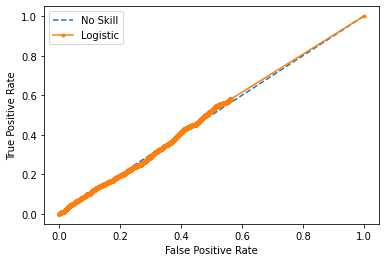

In [44]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [18]:

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
accuracy = dt.score(X_test_scaled, y_test)
print(f"Accuracy:{accuracy}")
print(classification_report(y_test, y_pred))
print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred))}")


Accuracy:-0.8540328169852163
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     13903
           1       0.90      0.92      0.91     13750

    accuracy                           0.91     27653
   macro avg       0.91      0.91      0.91     27653
weighted avg       0.91      0.91      0.91     27653

R2 score: 0.6432827551934506
Mean Absolute Error: 0.08917658120276281
Mean Squared Error: 0.2986244819212966


In [19]:
model = DecisionTreeRegressor()
regr_trans = TransformedTargetRegressor(regressor=model, transformer=QuantileTransformer(output_distribution='normal'))
regr_trans.fit(X_train, y_train)
y_pred = regr_trans.predict(X_test)
accuracy = dt.score(X_test_scaled, y_test)
print(f"Accuracy:{accuracy}")
print(classification_report(y_test, y_pred))
print(f"R2 score: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, y_pred)}")
print(f"Mean Squared Error: {np.sqrt(mean_squared_error(y_test, y_pred))}")

Accuracy:-0.8540328169852163
              precision    recall  f1-score   support

           0       0.92      0.90      0.91     13903
           1       0.90      0.92      0.91     13750

    accuracy                           0.91     27653
   macro avg       0.91      0.91      0.91     27653
weighted avg       0.91      0.91      0.91     27653

R2 score: 0.6398110545140681
Mean Absolute Error: 0.09004447980327632
Mean Squared Error: 0.3000741238482191
